# Resumo do Desafio

A Giant Steps começou operar na bolsa de Gotham City e recebe no final do dia o arquivo `gotham_op.txt` disponibilizado pela bolsa da cidade que contém os registros das operações.

Este arquivo deverá ser validado e interpretado com o propósito de se obter um resumo das operações do dia e identificar problemas no arquivo.

## Minha abordagem ao problema

1. Fazer o importe do [Pandas](https://pandas.pydata.org/), a melhor biblioteca para manipulação de uma grande quantidade de dados.
2. Tendo em vista que os dados possuem inconsistências na formatação, o próximo passo que tomo é construir uma função que consiga formatar os dados extraidos do arquivo ``gotham_op.txt`` , e ao mesmo tempo extraia os erros durante a formatação.
3. Já com o DataFrame construido, posso fazer a soma das compras e vendas de cada ativo sem nenhum empecilho e entregar esses dados classificados por ação em um gráfico no fim desse arquivo, e em um arquivo separado chamado ``results.txt``.
<br />
**EXTRA:** Criarei também um script para que vcs possam rodar o código fora do Jupyter e receber o resultado direto


## Importes e extração dos dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

with open('gotham_op.txt') as f:
    lines = f.readlines()

## Funções

**Find_errors_and_format:** Função que permite achar os erros de formatação nas informações recebidas e estrutura e prepara os dados em forma de DataFrame. Para uso é necessário passar o parâmetro: 
* **lines** - Lista onde cada elemento representa uma linha do arquivo recebido

**A função retorna dois valores:**
 * **primeiro:** DataFrame das operações válidas feitas
 * **segundo:** Dicionário de operações mal formatadas onde a key é o tipo de erro de formatação e o value é uma lista com as linhas no arquivo que apresemtam erros.
 
**OBS:** Fiz uma mudança no valor da variável SIDE pois deixar em um valor numérico de ``1`` para compra e ``-1`` para venda iria facilitar na hora de fazer os cálculos na função seguinte


In [2]:
def find_errors_and_format(lines):
    bad_format = {"SIDE": [], "QTY_INV": [], "QTY_NEG": [], "TICKER": []}
    dic = {}
    #Loop para pegar as linas do arquivo
    for i in range(len(lines)):
        line_dic = {}
        valid = True;
        line_broked = lines[i][:-1].split(";")
        #Loop para pegar os atributos das linas que foram separados por ``;``
        for attribute in line_broked:
            #Verificação da formatação dos SIDES
            if "SIDE" in attribute:
                #Se é BUY ou SELL aceita o SIDE como validado e atribui -1 quando é SELL e 1 quando é BUY
                if "BUY" in attribute:
                    line_dic["SIDE"] = 1
                elif "SELL" in attribute:
                    line_dic["SIDE"] = -1
                else:
                    valid = False;
                    bad_format["SIDE"].append(i+1)
            #Verificação da formatação das QTYS
            if "QTY" in attribute:
                #Analisando se o QTY tem números atribuidos e se são válidos
                if attribute[4:].isdecimal() and int(attribute[4:])>0 and int(attribute[4:])%10==0:
                    line_dic["QTY"] = int(attribute[4:])
                #Verifica se o problema foi o fato dos números não serem válidos
                elif attribute[4:].isdecimal():
                    valid = False;
                    bad_format["QTY_NEG"].append(i+1)
                #Ou se o valor atribuido não é um número
                else:
                    valid = False;
                    bad_format["QTY_INV"].append(i+1)
            #Verificação da formatação dos TICKERS
            if "TICKER" in attribute:
                #Verifica se a formatação respeita o padrão 4 letras + 1 algarismo
                if len(attribute)==12 and attribute[-1:].isdecimal() and not attribute[-2:].isdecimal():
                    line_dic["TICKER"] = attribute[7:]
                else:
                    valid = False;
                    bad_format["TICKER"].append(i+1)
        #Verifíca se algum dos campos recebeu um erro
        if valid:
            dic[i] = line_dic
    #Converte o dicionário em DataFrame ao designar o Value de cada Key no dicionário para uma row do DataFrame
    df = pd.DataFrame([v for k, v in dic.items()], columns=['SIDE', 'QTY', 'TICKER'])
    return df, bad_format

**Sum_tickers_and_create_result:** Multiplica a quantidade de TICKERS operacionados pelo fator SIDE que agora é -1 para vendas e 1 para compras, depois soma todas as operações de mesmo TICKER. Para uso é necessário passar o parâmetro: 
* **df** - DataFrame contendo as informações do arquivo formatadas pela função ``find_errors_and_format``

**A função retorna um valor:**
 * **primeiro:** DataFrame de Tickers por QTY e SIDE_RESULT
 ### SIDE_RESULT: Representa qual foi o tipo de operação mais feita para uma ação e quantas vezes mais ela foi efetuada. 
<br />
**Exemplo:** SIDE_RESULT -3  --> por ser negativo essa ação teve 3 vendas a mais que compras


In [3]:
def sum_tickers_and_create_result(df):
    df.QTY = df.SIDE*df.QTY
    df2 = df.groupby(['TICKER']).sum()
    df2.rename(columns={'SIDE': 'SIDE_RESULT'}, inplace = True)
    return df2

## Executando as funções e salvando resultados em um txt

In [4]:
df,dic_errors = find_errors_and_format(lines)
df = sum_tickers_and_create_result(df)
df

,SIDE_RESULT,QTY
TICKER,,
ACEC4,3,480
LEXC0,2,4900
PALM9,2,600
WAYN3,-1,4320


In [5]:
open('results.txt', 'w').close()
df.to_csv(r'results.txt', sep=';', mode='a')

## Gráfico da quantidade de operações por ação

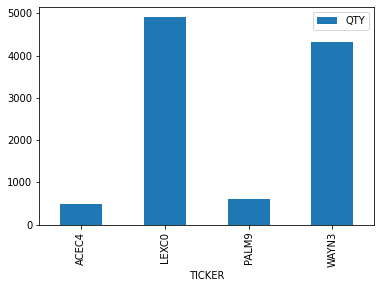

In [6]:
df_plt = pd.DataFrame(df["QTY"])
df_plt.plot(kind = 'bar', stacked=True)
plt.show()